<a href="https://colab.research.google.com/github/T-yuu/hello/blob/master/AKAZE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AKAZE

本ノートブックでは画像からAKAZEを用いて特徴点を抽出し特徴量を作成することである。

### Library


In [58]:
import os
import math
import random
from typing import List, Optional

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

### Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DEBUG = True
DATADIR = "/content/drive/MyDrive/kiva_img/"
train_df = pd.read_csv(os.path.join(DATADIR, "train.csv"))
test_df = pd.read_csv(os.path.join(DATADIR, "test.csv"))

print(f"train data shpae: {train_df.shape}")
print(f"test data shape: {test_df.shape}")

display(train_df.head())
display(test_df.head())

train data shpae: (91333, 18)
test data shape: (91822, 17)


,LOAN_ID,ORIGINAL_LANGUAGE,DESCRIPTION,DESCRIPTION_TRANSLATED,LOAN_AMOUNT,IMAGE_ID,ACTIVITY_NAME,SECTOR_NAME,LOAN_USE,COUNTRY_CODE,COUNTRY_NAME,TOWN_NAME,CURRENCY_POLICY,CURRENCY_EXCHANGE_COVERAGE_RATE,CURRENCY,TAGS,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL
0,1733169,English,Teodora is a 50-year-old married woman from th...,Teodora is a 50-year-old married woman from th...,100,3115271,Weaving,Arts,"to purchase materials like nipa palm, bamboo ...",PH,Philippines,"Maribojoc, Bohol",shared,0.1,PHP,#Elderly,monthly,field_partner
1,1546998,English,Diego is 32 years old and lives in the municip...,Diego is 32 years old and lives in the municip...,1350,2870403,Barber Shop,Services,"to buy two hair clippers, a new barber chair, ...",CO,Colombia,Apartadó,shared,0.1,COP,"user_favorite, user_favorite",monthly,field_partner
2,1808517,Spanish,"Osman, es un joven de 27 años de edad, soltero...","Osman is a young man, 27 years old, single, an...",225,3215705,Farming,Agriculture,to purchase sacks of fertilizers to care for a...,HN,Honduras,"Nueva Frontera, Santa Barbara.",shared,0.1,HNL,NaN,bullet,field_partner
3,1452940,English,"His name is Nino, 31 years old, married to Che...","His name is Nino, 31 years old, married to Che...",350,2745031,Motorcycle Transport,Transportation,"to pay for fuel, tires and change oil for his ...",PH,Philippines,"Silang, Cavite",shared,0.1,PHP,user_favorite,monthly,field_partner
4,1778420,English,"Pictured above is Teresa, often described as a...","Pictured above is Teresa, often described as a...",625,3083800,Farming,Agriculture,to purchase hybrid seeds and fertilizer to imp...,KE,Kenya,Mumias,shared,0.1,KES,"#Eco-friendly, #Sustainable Ag, #Parent, #Elde...",bullet,field_partner


,LOAN_ID,ORIGINAL_LANGUAGE,DESCRIPTION,DESCRIPTION_TRANSLATED,IMAGE_ID,ACTIVITY_NAME,SECTOR_NAME,LOAN_USE,COUNTRY_CODE,COUNTRY_NAME,TOWN_NAME,CURRENCY_POLICY,CURRENCY_EXCHANGE_COVERAGE_RATE,CURRENCY,TAGS,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL
0,2041445,English,Marcela is 69 years old and married with ten c...,Marcela is 69 years old and married with ten c...,4051101,General Store,Retail,to buy items to sell like canned goods and per...,PH,Philippines,"Cauayan, Negros Occidental",standard,NaN,PHP,NaN,monthly,field_partner
1,1944435,English,Roselia is 48 years old and has five children....,Roselia is 48 years old and has five children....,3410523,Pigs,Agriculture,to buy feeds and other supplies to raise her pig,PH,Philippines,"Guihulngan, Negros Oriental",standard,NaN,PHP,"#Animals, #Repeat Borrower, #Schooling, #Woman...",monthly,field_partner
2,2083354,English,"Ma. Marebil is a single woman, 40 years old wi...","Ma. Marebil is a single woman, 40 years old wi...",4146690,Clothing Sales,Clothing,to buy additional stock of clothes and dresses...,PH,Philippines,"Santa Barbara, Iloilo",standard,NaN,PHP,"#Parent, #Single Parent, #Woman-Owned Business",monthly,field_partner
3,1993565,English,"Good day, lenders! Meet one of KBMI’s clients,...","Good day, lenders! Meet one of KBMI’s clients,...",3945982,Food,Food,to buy more foods to grow her business.,ID,Indonesia,Pandeglang,shared,0.1,IDR,"#Woman-Owned Business, #Schooling, #Elderly, #...",monthly,field_partner
4,2064272,English,Rosemarie is a married woman with two children...,Rosemarie is a married woman with two children...,4114040,Food,Food,to buy ingredients for her food production bus...,PH,Philippines,Sogod Cebu,standard,NaN,PHP,NaN,monthly,field_partner


In [4]:
!cp "/content/drive/My Drive/kiva_img/test_images.zip" .
!unzip test_images.zip
!cp "/content/drive/My Drive/kiva_img/train_images.zip" .
!unzip train_images.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: train_images/3036079.jpg  
  inflating: train_images/2805142.jpg  
  inflating: train_images/3135706.jpg  
  inflating: train_images/3345964.jpg  
  inflating: train_images/3324463.jpg  
  inflating: train_images/2764845.jpg  
  inflating: train_images/3007972.jpg  
  inflating: train_images/2969700.jpg  
  inflating: train_images/3050427.jpg  
  inflating: train_images/2797675.jpg  
  inflating: train_images/3156558.jpg  
  inflating: train_images/3180195.jpg  
  inflating: train_images/3315484.jpg  
  inflating: train_images/3018628.jpg  
  inflating: train_images/2957591.jpg  
  inflating: train_images/3228967.jpg  
  inflating: train_images/3165885.jpg  
  inflating: train_images/3217960.jpg  
  inflating: train_images/3345822.jpg  
  inflating: train_images/3322453.jpg  
  inflating: train_images/3026834.jpg  
  inflating: train_images/3297197.jpg  
  inflating: train_images/3093814.jpg  
  inflating: train_images/3138383.jpg  
  inflat

### Preprocessing

#### 画像の欠損値処理

In [5]:
# DataFrameに画像の相対パスを追加
train_df['img_path'] =\
    train_df['IMAGE_ID'].apply(lambda x: f"/content/train_images/{x}.jpg")
test_df['img_path'] =\
    test_df['IMAGE_ID'].apply(lambda x: f"/content/test_images/{x}.jpg")
train_df['IMAGE_PATH'] =\
    train_df['IMAGE_ID'].apply(lambda x: f"{x}.jpg")
test_df['IMAGE_PATH'] =\
    test_df['IMAGE_ID'].apply(lambda x: f"{x}.jpg")

# 画像があるかどうかフラグをつける
train_df['image_exist'] = 0
test_df['image_exist'] = 0

exist_image = os.listdir("/content/train_images/")
for i in range(train_df.shape[0]):
    if train_df.loc[i, "IMAGE_PATH"] in exist_image:
        train_df.loc[i, "image_exist"] = 1
print('number of non exitst image id in training img ',train_df.shape[0]-len(exist_image))

exist_image = os.listdir("/content/test_images/")
for i in range(test_df.shape[0]):
    if test_df.loc[i, "IMAGE_PATH"] in exist_image:
        test_df.loc[i, "image_exist"] = 1
print('number of non exitst image id in test img ',test_df.shape[0]-len(exist_image))

# 画像があるデータとないデータで分割する
use_train_df = train_df.query("image_exist == 1")
unuse_train_df = train_df.query("image_exist == 0")
#del train_df

number of non exitst image id in training img  304
number of non exitst image id in test img  3


#### AKAZEによる特徴量抽出

特徴点の個数、各特徴点の特徴量記述子ベクトルの平均値・分散を特徴量として求める。

In [53]:
def akaze(PARAM):
  EXIST,IMAGE_PATH = PARAM
  if EXIST==0:
    return pd.Series([0]*123)
  img = cv2.imread(IMAGE_PATH)
  detector = cv2.AKAZE_create()
  kp,desc = detector.detectAndCompute(img, None)
  if len(kp)==0:
    return pd.Series([-1]*123)
  return pd.Series([len(kp)]+np.mean(desc,axis=0).tolist()+np.var(desc,axis=0).tolist())

学習データ

In [54]:
train_img_df = train_df[['image_exist','img_path']].apply(akaze,axis=1)
train_img_df['LOAN_ID'] = train_df['LOAN_ID']
train_img_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,LOAN_ID
0,76.0,71.421053,131.986842,68.828947,45.289474,88.592105,120.723684,98.434211,125.894737,159.921053,153.078947,145.407895,90.328947,108.052632,98.750000,213.710526,147.802632,73.934211,99.776316,63.539474,136.763158,81.578947,92.302632,96.171053,98.934211,55.315789,61.092105,65.092105,111.802632,157.171053,143.710526,112.763158,107.118421,119.618421,117.065789,137.776316,143.460526,149.026316,89.618421,125.052632,...,7162.510215,6553.877251,6645.058172,6419.294148,7303.504675,8724.289993,7981.641794,8990.310942,6398.233380,7151.709661,7072.893871,8564.614093,8039.857860,7974.458968,6268.551939,5678.499134,6954.549861,8609.162569,9145.443213,8164.551766,9358.628809,4582.108553,7188.762292,7359.039301,8816.288608,7137.316309,7931.644564,7655.862188,11218.102493,9174.123788,8052.827389,8127.413262,9390.831544,10270.157202,10081.710526,9509.087950,8996.877424,10612.360630,528.132964,1733169
1,186.0,77.989247,106.408602,65.016129,35.456989,96.397849,58.241935,102.290323,119.784946,143.489247,118.408602,149.086022,84.806452,98.629032,104.037634,202.763441,142.424731,73.032258,102.516129,50.559140,100.408602,37.741935,67.682796,91.892473,90.311828,28.155914,25.274194,47.989247,92.408602,112.629032,90.887097,115.086022,107.107527,121.145161,116.413978,122.198925,142.241935,141.215054,91.139785,103.198925,...,6358.085212,6710.053301,3270.045583,2622.263528,6284.881605,8814.338421,8044.663458,8894.100156,6907.014106,8481.913169,6997.134842,8831.833998,7160.836773,8376.269424,7690.373107,6654.389062,6086.664730,8909.947769,8952.788328,7521.482050,7765.605272,7043.855619,8150.837900,7233.506215,6218.066482,7044.924529,7614.400884,8376.178633,10501.799052,8144.025581,7728.046971,6837.606111,10600.520089,10547.593970,9717.436235,8623.321771,7078.286507,9823.922881,468.000838,1546998
2,216.0,73.300926,127.018519,94.305556,61.486111,95.625000,106.699074,127.194444,120.268519,137.546296,140.694444,141.662037,114.986111,119.037037,92.902778,210.754630,132.990741,80.365741,112.532407,80.509259,112.166667,77.287037,79.143519,117.773148,114.592593,66.675926,61.583333,84.337963,85.944444,152.824074,111.921296,129.328704,126.754630,116.879630,113.032407,131.120370,152.254630,137.509259,124.509259,109.175926,...,7763.647612,7670.574760,6967.422754,7083.557870,9331.362633,8670.024691,7896.848680,9698.146584,7110.183621,8282.351830,7822.615141,8753.512839,7776.059585,7247.300904,7796.712877,8418.972136,5975.413495,8037.776728,7482.528785,7702.651042,8141.245863,5669.433621,7261.814729,7057.769011,8827.728309,9141.789009,8923.814043,9278.330247,9978.845143,9233.612054,8820.572338,7614.666645,9606.559992,9869.278785,9006.455676,9267.063079,6554.948881,10018.905671,455.094564,1808517
3,211.0,73.658768,135.407583,85.473934,47.729858,101.796209,92.933649,92.933649,122.431280,149.592417,125.336493,139.838863,116.511848,115.853081,96.236967,206.464455,132.507109,78.142180,91.355450,63.914692,109.393365,61.208531,65.587678,108.094787,116.208531,53.421801,45.791469,58.056872,120.644550,150.554502,98.146919,107.601896,100.909953,128.606635,118.052133,121.592417,150.146919,150.592417,96.748815,101.000000,...,6939.829878,9092.221918,7168.869477,5281.558411,7237.484917,10560.456594,8833.479257,8800.883628,7054.400755,8848.034545,6942.342894,8497.139462,7850.421554,8742.551874,7556.535298,6825.126480,6863.289100,8927.009232,7916.561712,8272.836729,9276.690056,6415.202084,7921.559938,6995.577143,8323.422385,7463.159004,7986.019811,7780.967319,10104.903349,8486.444285,8621.197098,7032.657712,8901.061836,9515.000382,9009.537522,8933.581725,8016.262168,11046.112037,477.926776,1452940
4,104.0,110.394231,115.817308,66.788462,51.846154,93.807692,72.028846,122.355769,127.134615,148.057692,137.634615,135.509615,106.

In [55]:
train_img_df.to_csv(os.path.join(DATADIR,'train_img_akaze.csv'))

テストデータ

In [56]:
test_img_df = test_df[['image_exist','img_path']].apply(akaze,axis=1)
test_img_df['LOAN_ID'] = test_df['LOAN_ID']
test_img_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,LOAN_ID
0,118.0,81.983051,79.855932,105.118644,55.661017,111.627119,46.610169,89.254237,121.101695,149.245763,102.483051,142.957627,67.313559,72.966102,83.533898,202.830508,147.796610,111.644068,113.644068,77.881356,138.144068,56.966102,93.347458,114.262712,94.881356,37.245763,28.542373,52.932203,65.110169,91.762712,71.305085,124.661017,109.694915,125.127119,102.033898,126.627119,138.008475,141.533898,82.127119,92.762712,...,8456.414033,6838.104568,5438.456550,3810.010916,8108.029302,7340.860744,5854.299627,7915.754381,6794.122379,8266.195059,7303.704180,7927.083597,7563.318587,10549.449081,6986.214953,6904.110959,5714.909796,9597.665398,9783.882290,9854.510773,9832.101192,5766.411951,9179.492459,8196.372020,4851.911591,6762.942330,6601.065211,8412.294815,8396.068371,7033.950876,8648.503878,7727.820167,12157.419132,12496.413746,11835.479244,9801.668845,6166.435004,8513.575768,562.101695,2041445
1,59.0,72.881356,99.169492,52.423729,22.423729,73.711864,65.220339,109.525424,146.101695,150.813559,146.864407,154.508475,90.864407,88.542373,83.559322,228.271186,138.491525,66.067797,89.677966,40.813559,92.813559,24.830508,58.033898,80.067797,79.135593,22.135593,31.677966,49.830508,78.711864,127.220339,67.559322,122.169492,106.389831,118.915254,101.830508,145.932203,183.169492,159.610169,97.169492,118.881356,...,7904.978454,8360.422292,3312.795174,4022.930192,6849.191612,9639.154266,6532.070095,7196.144786,9097.361103,9232.983625,7859.467394,7636.615340,7209.046251,8222.445849,6697.322608,6051.835679,8268.138466,9493.451307,8539.841999,9191.793163,11316.659006,6435.017524,8580.745763,7389.197357,7186.129848,5767.841425,6649.125539,7359.062338,12181.774203,8419.932778,7055.727664,7265.786268,11115.709279,11825.308245,10496.163746,8504.247055,5638.384372,7233.529446,585.053146,1944435
2,138.0,82.949275,94.297101,94.217391,49.615942,111.391304,62.884058,124.347826,119.695652,141.072464,149.913043,156.492754,84.347826,81.413043,87.565217,198.217391,141.188406,95.804348,116.195652,79.485507,128.898551,46.137681,76.536232,107.420290,107.601449,28.195652,29.949275,53.521739,92.166667,133.297101,68.833333,140.043478,124.818841,115.659420,114.079710,124.630435,150.811594,144.905797,118.644928,115.688406,...,6067.084226,7725.239708,2375.099401,2643.439456,6175.191556,9034.225845,7646.324774,7419.849034,7368.708255,8775.061384,8304.065165,8655.218284,7967.740233,8767.051460,8650.621561,7946.026097,5976.156532,8644.376181,8513.278933,8989.930529,7968.418399,6170.756406,7451.200168,6621.745064,7321.023735,7431.674648,8358.497164,8740.853182,9831.243646,7563.173073,9213.430214,8476.858643,10753.963296,10809.388574,10719.858013,10704.138259,6150.210880,10220.729311,573.788542,2083354
3,120.0,87.416667,97.091667,89.200000,72.433333,121.033333,66.908333,124.741667,122.941667,144.583333,124.891667,137.791667,93.008333,91.775000,90.333333,222.775000,122.533333,82.041667,120.891667,80.125000,141.641667,80.375000,97.416667,106.416667,100.141667,48.216667,39.850000,62.325000,89.933333,121.333333,102.233333,132.783333,133.516667,132.966667,119.950000,128.166667,143.516667,131.508333,101.775000,106.783333,...,7417.859722,6780.321597,7132.569722,5687.277500,8363.736042,9773.195556,8034.688889,11111.878889,7965.986389,9900.516389,8013.915556,9277.714167,8539.922222,9091.349722,9473.149931,8153.941042,5663.319722,9297.594167,8659.074375,8250.929931,9191.745556,5691.763264,8219.178889,7221.614167,6862.488264,9494.007708,7264.163264,9658.299375,10258.834375,7722.738889,8541.829931,6800.872222,9009.949931,10885.740000,9741.758264,7301.348889,7414.349722,8689.086389,536.819722,1993565
4,44.0,74.500000,86.136364,71.568182,31.500000,87.568182,34.772727,97.545455,111.159091,151.000000,131.681818,144.113636,96.659091,99

In [57]:
test_img_df.to_csv(os.path.join(DATADIR,'test_img_akaze.csv'))

### 特徴量の可視化

TSNEによる次元圧縮と目的変数を可視化。

In [59]:
X = TSNE().fit_transform(train_img_df.drop(columns='LOAN_ID'))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


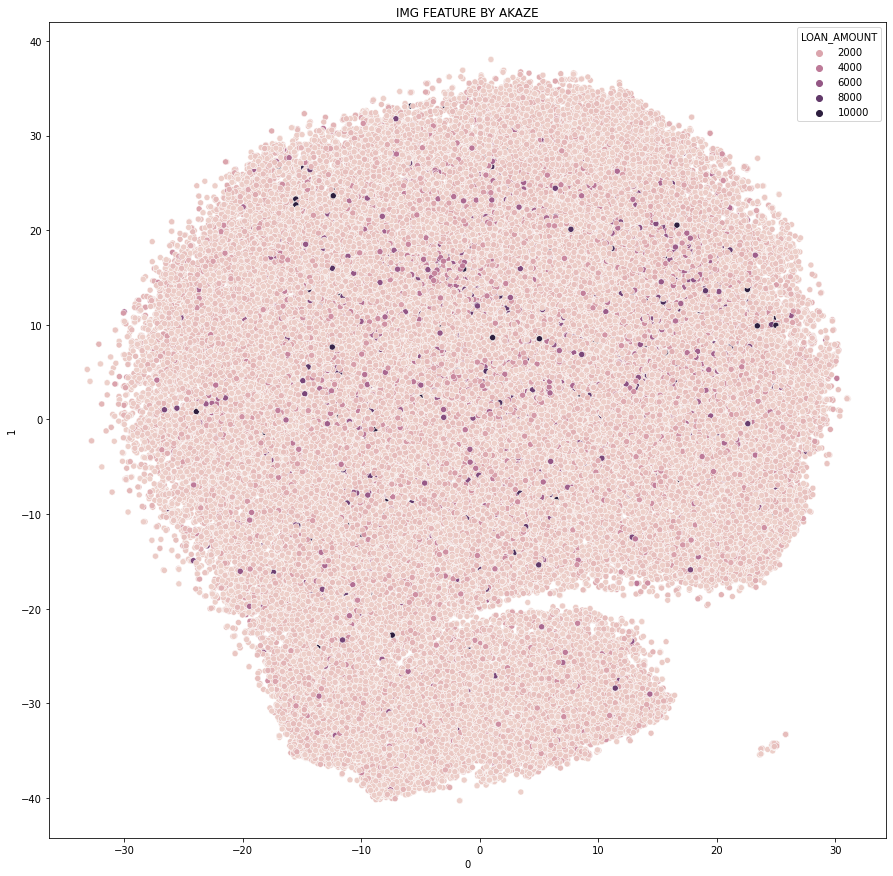

In [64]:
E = pd.DataFrame(X)
plt.figure(figsize=(15,15))
E['LOAN_AMOUNT'] = train_df['LOAN_AMOUNT'].tolist()
sns.scatterplot(data=E,x=0,y=1,hue='LOAN_AMOUNT')
plt.title('IMG FEATURE BY AKAZE')
plt.show()